In [727]:
# library imports
from importlib import reload
from copy import deepcopy
from Classes import ClusterObj, BlockObj, ScanDataObj
from Functions import CommonFunctions, ClassesFunctions
import pickle
import pandas as pd
reload(CommonFunctions)
reload(ClassesFunctions)
reload(ClusterObj)
reload(BlockObj)
reload(ScanDataObj)

print('Done!')

Done!


In [728]:
# import os
# import pandas as pd
# from openpyxl import load_workbook
#
# def combine_excel_files(input_folder):
#     sheet_data = {}
#
#     # Collect all data into a dictionary with sheet names as keys
#     for file in os.listdir(input_folder):
#         if file.endswith("summary.xlsx"):
#             file_path = os.path.join(input_folder, file)
#
#             # Extract the custom sheet name based on the filename
#             parts = file.split("_")
#             if len(parts) >= 4:
#                 sheet_name = f"{parts[0]}_{parts[3]}"  # Combine the first and fourth parts
#                 sheet_name = sheet_name[:31]  # Limit to 31 characters (Excel's limit)
#             else:
#                 sheet_name = file[:31]  # Fallback to file name if not enough parts
#
#             try:
#                 # Read the Excel file
#                 df = pd.read_excel(file_path, engine='openpyxl')
#
#                 # Remove '_0' or '_1' from dAb column names
#                 df.columns = [
#                     col[:-2] if col.startswith("dAb") and col[-2:] in ["_0"] else col
#                     for col in df.columns
#                 ]
#
#                 sheet_data[sheet_name] = df
#             except Exception as e:
#                 # Log the error and skip the file
#                 print(f"Failed to process {file}: {e}")
#
#     # Sort the dictionary by sheet name
#     sorted_sheets = dict(sorted(sheet_data.items()))
#
#     # Output file path (same folder as inputs)
#     output_file = os.path.join(input_folder, "combined_summary_results.xlsx")
#
#     # Write sorted sheets to the output Excel file
#     with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
#         for sheet_name, df in sorted_sheets.items():
#             df.to_excel(writer, sheet_name=sheet_name, index=False)
#
#     # Adjust column widths for dAb columns
#     workbook = load_workbook(output_file)
#     for sheet_name in workbook.sheetnames:
#         worksheet = workbook[sheet_name]
#         for col in worksheet.columns:
#             col_letter = col[0].column_letter
#             if col[0].value and str(col[0].value).startswith("dAb"):
#                 worksheet.column_dimensions[col_letter].width = 15
#             else:
#                 worksheet.column_dimensions[col_letter].width = 10
#     workbook.save(output_file)
#
#
# path = "/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/P24-1204"
#
# combine_excel_files(path)


In [729]:
# import pandas as pd
# import re
# from openpyxl import load_workbook
#
#
# def sanitize_sheet_name(sheet_name):
#     # Replace invalid characters with an underscore
#     return re.sub(r'[\\/:*?\"<>|]', '_', sheet_name)
#
# def group_unique_combinations_and_save(input_file):
#     # Load the combined Excel file
#     combined_df = pd.read_excel(input_file, sheet_name=None, engine='openpyxl')
#     workbook = load_workbook(input_file)
#
#     # Create a dictionary to store the grouped columns by unique combinations of dAb and cAb
#     grouped_columns = {}
#
#     # Iterate through all sheets in the combined file
#     for sheet_name, df in combined_df.items():
#         # Skip hidden sheets
#         if workbook[sheet_name].sheet_state == 'hidden':
#             continue
#
#         for col in df.columns:
#             # Identify if the column starts with 'dAb' followed by '_cAb'
#             if col.startswith('dAb') and ('_cAb' in col or 'anti_' in col):
#                 # Extract the combination of 'dAbX_cAbY' (e.g., 'dAb10_cAb11')
#                 base_name = '_'.join(col.split('_')[:2])
#
#                 # Initialize the base name dictionary if it doesn't exist
#                 if base_name not in grouped_columns:
#                     grouped_columns[base_name] = {'SD4': [], 'OF': []}
#
#                 # Append the column to the appropriate sheet type (SD4 or OF)
#                 if sheet_name.endswith('_SD4'):
#                     grouped_columns[base_name]['SD4'].append((sheet_name, col))
#                 elif sheet_name.endswith('_OF'):
#                     grouped_columns[base_name]['OF'].append((sheet_name, col))
#
#     # Create a new Excel file with the grouped columns
#     output_file = input_file.replace('.xlsx', '_grouped_unique_combinations.xlsx')
#
#     with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
#         # For each unique combination of dAb and cAb
#         for group_name, sheet_types in grouped_columns.items():
#             # For each sheet type (SD4 and OF)
#             for sheet_type, column_info in sheet_types.items():
#                 # Prepare a list to store columns
#                 columns_list = []
#                 if len(column_info) < 1 :
#                     continue
#                 # Add ag_conc column to the list as the first column
#                 ag_conc_col = combined_df[column_info[0][0]]['Ag_Conc.']  # Getting ag_conc from the first sheet
#                 columns_list.append(ag_conc_col.rename('Ag_Conc.'))
#
#                 # Add the columns corresponding to this group
#                 for idx, (sheet_name, col_name) in enumerate(column_info):
#                     # Add columns with new names ('sheetX', 'sheetX_01', etc.)
#                     new_column_name = f"{sheet_name}_{idx}"
#                     columns_list.append(combined_df[sheet_name][col_name].rename(new_column_name))
#
#                 # Concatenate all columns in one DataFrame
#                 new_df = pd.concat(columns_list, axis=1)
#                 sanitized_sheet_name = sanitize_sheet_name(f"{group_name}_{sheet_type}")
#
#                 # Write the grouped DataFrame to a new sheet in the Excel file
#                 # new_sheet_name = f"{group_name}_{sheet_type}"
#                 new_df.to_excel(writer, sheet_name=sanitized_sheet_name, index=False)
#      # Adjust column widths for dAb columns
#     workbook = load_workbook(output_file)
#     for sheet_name in workbook.sheetnames:
#         worksheet = workbook[sheet_name]
#         for col in worksheet.columns:
#             col_letter = col[0].column_letter
#             if col[0].value and str(col[0].value).startswith("Day"):
#                 worksheet.column_dimensions[col_letter].width = 15
#             else:
#                 worksheet.column_dimensions[col_letter].width = 10
#     workbook.save(output_file)
#     print(f"Grouped file saved as {output_file}")
#
# # Example usage
# group_unique_combinations_and_save(f"{path}/combined_summary_results.xlsx")


In [730]:
# path setup
path = "/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/P25_0114/"
input_file_name = 'Day5_S2_N5_SD4_5um'

image, scaled_image = CommonFunctions.load_image(file_name=input_file_name, path=path, debug=False, plot_images=False, rotation=0)
print(f'Loaded Image "{input_file_name}" {image.shape}')


Loaded Image "Day5_S2_N5_SD4_5um" (14400, 4400)


In [731]:
# load the saved work, or start over:
scan_data = ClassesFunctions.read_scan_data_from_pickle(
    file_name=input_file_name,
    path=path,
    start_over=False, # if True -> ignores the pickle, and returns None for initiating with the following functions
    plot_results=False,
    debug=False
)

overwrite_params = 0
if not scan_data or overwrite_params:
    print('Need to start over and make the dataset')
    start_over = True
    CommonFunctions.show(scaled_image)
else:
    print(f'Successfully loaded scan_data for "{input_file_name}"')
    start_over = False



Successfully loaded scan_data for "Day5_S2_N5_SD4_5um"


In [732]:
## Setting the parameters:
input_param_dict = {
    'scan_size': 5,       # scanned at 5 or 10 µm
    'assay': 'SD4',       # put either "SD4" (screening D4) or "OF" (open format)
    'cAb_names': ['anti_cy5_0.7','anti_cy5_0.3','cAb49_DI','cAb49_Tre','cAb10_DI','cAb10_Tre','cAb35_DI','cAb35_Tre','cAb45_DI','cAb45_Tre','mix_cAbs','cAb28','mix_cAbs'] # can be None or [] too
}

In [733]:
input_param_dict.update({'eps': 990})

extra_keys = set(input_param_dict.keys()) - {'scan_size','assay','cAb_names'}
if start_over or extra_keys:
    ScanDataObj.init_or_reset_params(file_name=input_file_name, input_param_dict=input_param_dict, debug=False)

# test current parameters. can optimize them too if the results are not looking good.
if start_over:
    test_image = deepcopy(image)[100:1000,400:3000] #(y,x) -> change if u want!
    # checkme takes too long
    # CommonFunctions.optimize_the_params(file_name=input_file_name, input_image=test_image, how_many_times=1, plot_images=False, debug=0)
    CommonFunctions.test_current_parameters(input_image=test_image, file_name=input_file_name, fig_size=[9,9], debug=False)


Successfully set the params for Day5_S2_N5_SD4_5um with these given keys: dict_keys(['scan_size', 'assay', 'cAb_names', 'eps'])


In [734]:
# todo: add a function for parameter tuning...
ClassesFunctions.save_current_data_obj(file_name=input_file_name,path=path)
start_over

False

In [735]:
# start_over=True
if start_over or not hasattr(scan_data, 'sorted_circles') or not hasattr(scan_data, 'circle_finding_params_hough'):
    CommonFunctions.do_initial_circle_finding(file_name=input_file_name, debug=False, plot_images=False)
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
else:
    sorted_circles = scan_data.sorted_circles
    predicted_clusters_ids = scan_data.predicted_clusters_ids
ClassesFunctions.save_current_data_obj(file_name=input_file_name,path=path)
scan_data = ScanDataObj.get_scan_data(input_file_name)


In [736]:
start_over = True
if start_over:
    ClassesFunctions.init_blocks_dict(
        file_name=input_file_name,
        debug=False,
        # plot_blocks=start_over,
        debug_block_ids=[],
        init_offset=[-150,-100],
        block_size_adjustment=200, # keeping it square
        # block_distance_adjustment=[2,2],
    )

In [737]:
scan_data.block_size, scan_data.get_block('r0c3').min_max_coords_of_clusters

(1000, {'min_x': None, 'max_x': None, 'min_y': None, 'max_y': None})

In [738]:
# start_over = False
if start_over:
    ClassesFunctions.init_clusters_dict(
        scan_data.sorted_circles,
        scan_data.predicted_clusters_ids,
        input_file_name,
        optimize_spots_coords=False,
        debug=False, debug_clusters_ids=[4])
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

total detected spots: 1854
Optimized and added spot number 650, 

TypeError: int() can't convert non-string with explicit base

In [725]:
# connect clusters and blocks (and final initiation stuff)
# start_over = True
if start_over:
    ClassesFunctions.connect_clusters_to_blocks(file_name=input_file_name,debug=0,debug_clusters=[],debug_blocks=['r0c3'],plot_images=False,)

[connect_clusters_to_(230) - final_edits_after_ad(170)]: ** running final_edits_after_adding_clusters_to_block for blockr0c3

At first:  {'block_id': 'r0c3', 'row_number': 0, 'col_number': 3, 'start_x': 2920, 'end_x': 3920, 'start_y': 0, 'end_y': 1000, 'Ag_conc': None, 'file_name': 'Day5_S2_N5_SD4_5um', 'cAb_names': None, 'dAb_map_key': None, 'dAb_label': None, 'target': None, 'results_counts': None, 'fg_bg_calculated_flag': False, 'backup_start_x': 2920, 'backup_start_y': 0, 'dont_touch_this_block': None, 'clusters_ids_list': [3, 4, 9, 10, 14, 17], 'backup_clusters_ids_list': [], 'sorted_clusters_ids_list': [], 'intensities_dict_list': [], 'mask_start_coords': [0, 0], 'mask_end_coords': [0, 0], 'min_max_coords_of_clusters': {'min_x': None, 'max_x': None, 'min_y': None, 'max_y': None}}
[final_edits_after_ad(183) - update_min_max_coord(453)]: ** running update_min_max_coords_of_clusters for r0c3 & coords_list=None
[final_edits_after_ad(183) - update_min_max_coord(454)]: current min_max_

In [698]:
scan_data.block_size, scan_data.get_block('r0c3').min_max_coords_of_clusters

(1000, {'min_x': 3180, 'max_x': 3779, 'min_y': 202, 'max_y': 11469})

In [668]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)


	block_id: r0c3
	start_x: 2920
	end_x: 3920
	start_y: 0
	end_y: 1000
	backup_start_x: 2920
	backup_start_y: 0
	dont_touch_this_block: None
	clusters_ids_list: [3, 4, 9, 10, 14, 17]
	backup_clusters_ids_list: [3, 4, 9, 10, 14, 17]
	sorted_clusters_ids_list: []
	mask_start_coords: [0, 0]
	mask_end_coords: [0, 0]
	min_max_coords_of_clusters: {'min_x': 3180, 'max_x': 3779, 'min_y': 202, 'max_y': 11469}


	cluster_id: 3	spots_coords_list: total spots=5, spot0=[3576, 206, 16]
	spots_coords_in_block_list: total spots=5, spot0=[656 206  16]
	avg_x: 3675.6	avg_y: 203.6	avg_x_in_block: 755	avg_y_in_block: 203	avg_r: 17.8	block_id: r0c3	block_start_x: 2920	block_start_y: 0	backup_coords_list: total spots=5, spot0=[3576, 206, 16]
	backup_block_coords_list: total spots=5, spot0=[656 206  16]
	already_restored: False	merged_with_another: False	min_max_abs_coords: {'min_x': 3576, 'max_x': 3774, 'min_y': 202, 'max_y': 206}

	cluster_id: 4	spots_coords_list: total spots=6, spot0=[3227, 202, 18]
	spots

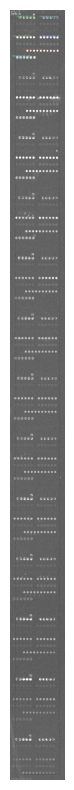

There are 6 clusters in total.


1000

In [669]:
## Making the first template of cluster patterns
start_over=True
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
test_ind = f'r0c3'
test_block: BlockObj.Block = scan_data.get_block(test_ind)
test_block.full_report()
if start_over:
    test_block.reset_block_start_end_coords(debug=1)
    manual_spot_edit_dict = {
        # 4:['del spot0','change_r spot0 r-2','change_r spot-1 r-1','add 1 to r','move spot-1 48 u, 50 l','change_r spot-1 r-3'],
        # 3:['change_r all r-2','change_r spot0 r+3','move spot0 1 u, 1 r','change_r spot2 r+3'],
        # 10:['change_r spot-2 r-2','add 2 to l','move spot0 1 l','add 1 cluster below d=100','add 2 clusters above d=100'],
        # 9:['add 2 clusters above d=100','add 1 clusters below d=100'],
        # 17:['add 2 to r','move spot-1 2 r'],
        # 14:['change_r spot0 r-2']
    }
    test_block.edit_block(debug=1, plot_before_after=False, overwrite=True,with_restore=True,
                          manual_spot_edit_dict=manual_spot_edit_dict)
    test_mask = test_block.create_block_mask(debug=1, plot_images=False)
    test_block.plot_block(fig_size=[10,10], debug=1, with_border=True, crop_to_mask=True)
    N = len(test_block.clusters_ids_list)
    print(f'There are {N} clusters in total.')
    # print(test_block.full_report(1))
scan_data.block_size


In [647]:
test_block.full_report()


	block_id: r0c3
	start_x: 2930
	end_x: 4180
	start_y: 0
	end_y: 11719
	backup_start_x: 2920
	backup_start_y: 0
	dont_touch_this_block: False
	clusters_ids_list: [3, 4, 9, 10, 14, 17]
	backup_clusters_ids_list: [3, 4, 9, 10, 14, 17]
	sorted_clusters_ids_list: []
	mask_start_coords: [200, 152]
	mask_end_coords: [899, 11519]
	min_max_coords_of_clusters: {'min_x': 3180, 'max_x': 3779, 'min_y': 202, 'max_y': 11469}


	cluster_id: 3	spots_coords_list: total spots=5, spot0=[3576, 206, 16]
	spots_coords_in_block_list: total spots=5, spot0=[646 206  16]
	avg_x: 3675.6	avg_y: 203.6	avg_x_in_block: 745	avg_y_in_block: 203	avg_r: 17.8	block_id: r0c3	block_start_x: 2930	block_start_y: 0	backup_coords_list: total spots=5, spot0=[3576, 206, 16]
	backup_block_coords_list: total spots=5, spot0=[656 206  16]
	already_restored: False	merged_with_another: False	min_max_abs_coords: {'min_x': 3576, 'max_x': 3774, 'min_y': 202, 'max_y': 206}

	cluster_id: 4	spots_coords_list: total spots=6, spot0=[3227, 202

In [567]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
# start_over

In [568]:
# generating the list to edit each row at the same time
generate_list = lambda n: [f'r{n}c{i}' for i in range(scan_data.block_ncol)]
rows_names_list = []
for r in range(scan_data.block_nrow):
    rows_names_list.append(generate_list(r))

In [585]:
# row 0
r = 0
plot_results = False if start_over else True
current_list = rows_names_list[r]
fig_size = [10,10] if scan_data.assay == 'SD4' else [15,15]
print(current_list,scan_data.block_size)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # restore_block_coords=current_list,
        # move_whole_block_match={'r0c0':[0,0],'r0c1':[0,-22],'r0c2':[0,0],'r0c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=[0],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={

        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

# print(scan_data.get_block('r0c1').full_report(1))

['r0c0', 'r0c1', 'r0c2', 'r0c3'] 1000


AttributeError: 'NoneType' object has no attribute 'astype'

blockr1c1 has 13 clusters which is wrong!
->[20, 21, 27, 28, 33, 34, 39, 284, 285, 286, 287, 288, 289]

 

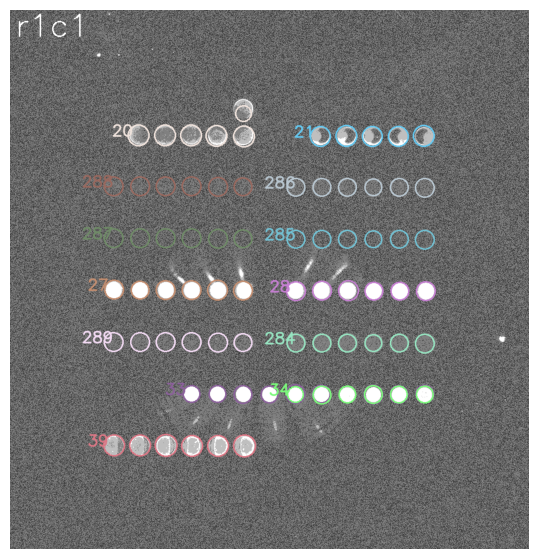

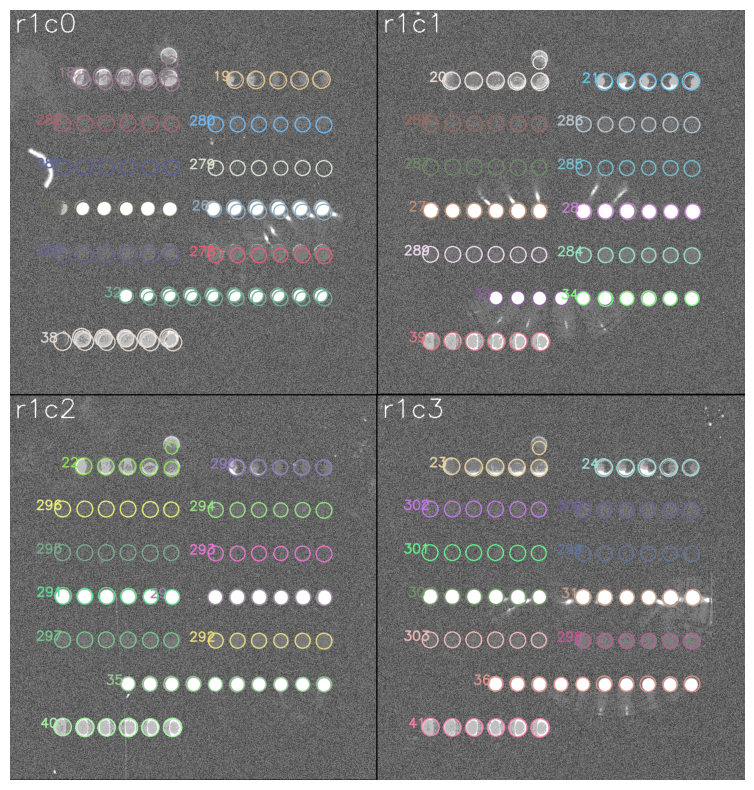

In [389]:
## row 1
r = 1
current_list = rows_names_list[r]

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        restore_block_coords=current_list,
        move_whole_block_match={'r1c0':[4,4],'r1c2':[0,0],'r1c3':[0,0]},
        manual_spot_edit_dict={
            37:['del']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

['r2c0', 'r2c1', 'r2c2', 'r2c3']

 

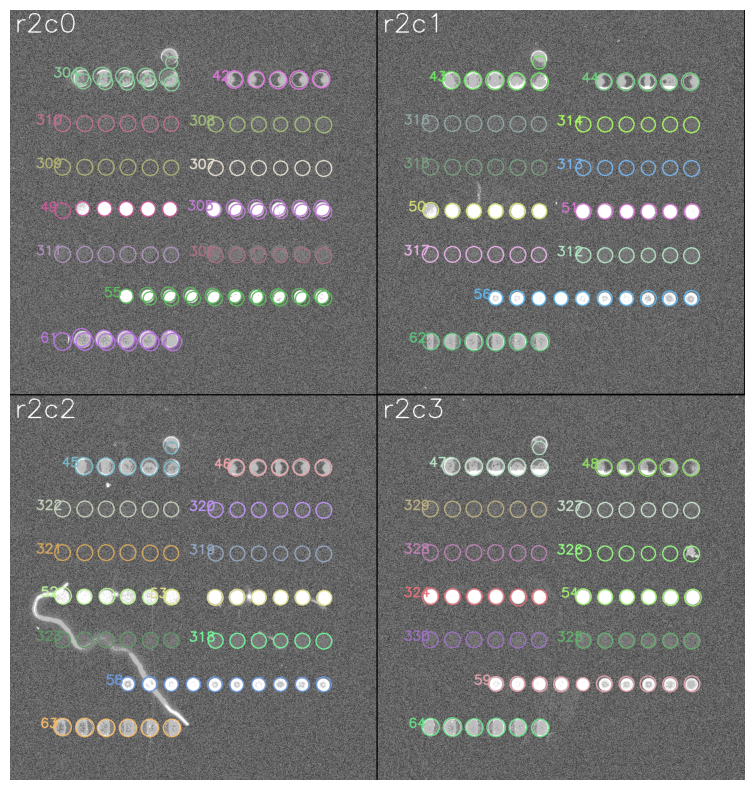

In [369]:
# row 2
r = 2
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # restore_block_coords=current_list,
        move_whole_block_match={'r2c0':[0,0],'r2c1':[0,0],'r2c2':[0,0],'r2c3':[0,0]},
        manual_spot_edit_dict={
            57:['del'],60:['del'],
            39:['del spot0'], 37:['del spot-1'],
            237:['change_r all r-2'],
            247:['change_r all r-2'],
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

In [ ]:
# row 3
r = 3
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # restore_block_coords=current_list,
        move_whole_block_match={'r3c0':[-50,0],'r3c1':[0,0],'r3c3':[0,0]},
        manual_spot_edit_dict={
            51:['del spot0']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 4
r = 4
start_over = 1
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # restore_block_coords=current_list,
        move_whole_block_match={'r4c0':[-50,0],'r4c1':[0,0],'r4c2':[0,0],'r4c3':[0,0]},
        manual_spot_edit_dict={
            # 64:['del spot0']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 5
r = 5
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # restore_block_coords=current_list,
        move_whole_block_match={'r5c0':[-50,0],'r5c1':[0,0], 'r5c3':[0,0]},
        manual_spot_edit_dict={
            85:['del'], 349:['add 1 cluster below d=100']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 6
r = 6
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # restore_block_coords=current_list,
        move_whole_block_match={'r6c0':[-50,0],'r6c3':[0,0]},
        manual_spot_edit_dict={
            94:['del spot-1']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 7
r = 7
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # restore_block_coords=current_list,
        move_whole_block_match={'r7c0':[-50,0], 'r7c1':[0,0],'r7c2':[0,0],'r7c3':[0,0]},
        manual_spot_edit_dict={
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 8
if scan_data.block_nrow > 8:
    r = 8
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
            debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
            preprocess_params=scan_data.preprocess_params, plot_before_after=0,
            # restore_block_coords=current_list,
            move_whole_block_match={'r8c0':[-50,0], 'r8c1':[-50,0],'r8c2':[0,0],},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 9
if scan_data.block_nrow > 8:
    r = 9
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            # restore_block_coords=current_list,
            move_whole_block_match={'r9c0':[-50,0],'r9c1':[-50,0],'r9c2':[0,0],'r9c3':[0,0]},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 10
if scan_data.block_nrow > 8:
    r = 10
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            restore_block_coords=current_list,
            move_whole_block_match={'r10c0':[-50,0],'r10c1':[-10,0],'r10c2':[0,0]},
            manual_spot_edit_dict={
                # 139:['change_r all r+1','move spot0 3 l, 6 d']
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)



In [ ]:
##### row 11
if scan_data.block_nrow > 8:
    r = 11
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            # restore_block_coords=current_list,
            move_whole_block_match={'r11c0':[-100,-10],'r11c1':[-50,0],'r11c2':[-20,0],'r11c3':[0,0]},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 12
if scan_data.block_nrow > 8:
    r = 12
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            restore_block_coords=current_list,
            move_whole_block_match={'r12c0': [-150,-10],'r12c1': [-70,0],'r12c2': [-50,0],'r12c3': [0,0],},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 13
if scan_data.block_nrow > 8:
    r = 13
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            restore_block_coords=current_list,
            move_whole_block_match={'r13c0': [-150,-20], 'r13c1': [-80,-20],'r13c2': [-20,0], 'r13c3': [0,0],},
            manual_spot_edit_dict={
            }
        )
    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 14
if scan_data.block_nrow > 8:
        r = 14
        current_list = rows_names_list[r]
        print(current_list)

        if start_over:
            ClassesFunctions.edit_multiple_blocks(
                current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
                debug=0, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
                restore_block_coords=current_list,
                move_whole_block_match={'r14c0':[-130,-30],'r14c1':[-90,-20],'r14c2':[-50,0],'r14c3':[0,0]},
                manual_spot_edit_dict={
                }
            )

        elif plot_results:
            ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 15
if scan_data.block_nrow > 8:
    r = 15
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            restore_block_coords=current_list,
            move_whole_block_match={'r15c0': [-160,-40],'r15c1': [-130,-20],'r15c2': [-60,-10],'r15c3': [-20,0]},
            manual_spot_edit_dict={
            }
        )


    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)


In [ ]:
scan_data.cAb_names = ['anti_cy5_0.7','anti_cy5_0.3','cAb49_DI','cAb49_Tre','cAb10_DI','cAb10_Tre','cAb35_DI','cAb35_Tre','cAb45_DI','cAb45_Tre','mix_cAbs','cAb28','mix_cAbs']

test_block.add_names_to_clusters(two_columns=1)
test_block.plot_block(description='cAb_names')

In [ ]:
scan_data.cAb_names

In [ ]:
## Additional test info and labeling
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
test_info = {'Ag': 'Omicron', 'dAb': 'dAb34'}

if scan_data.assay =='OF':
    curve_num_points = 8
    start_Ag_conc = 250
    dilution_factor = 2
    num_rep = 3
    num_blank_rows_at_bottom = 1
    test_info['start_blocks'] = ['r0c0','r0c1','r0c2']
    blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
    weird_dilution = False
else:
    curve_num_points = 16
    start_Ag_conc = 250
    dilution_factor = 2
    num_rep = 4
    num_blank_rows_at_bottom = 2
    test_info['start_blocks'] = ['r0c0','r0c1','r0c2','r0c3']
    scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
    blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
    weird_dilution = True

def add_labels(info_dict,debug=False, SD4_weird_dilution=False):
    for start_block_id in info_dict['start_blocks']:
        start_block = scan_data.get_block(start_block_id)
        start_block.dAb_label = info_dict['dAb']
        start_block.target = info_dict['Ag']
        start_block.Ag_conc = start_Ag_conc
        start_block.add_names_to_clusters(debug=debug)
        CommonFunctions.debug_report(f'{start_block_id}',debug)
        for n in range(1,curve_num_points):
            new_r = start_block.row_number + n
            new_block = scan_data.get_block(f'r{new_r}c{start_block.col_number}')
            new_block.dAb_label = info_dict['dAb']
            new_block.target = info_dict['Ag']
            if not SD4_weird_dilution:
                new_block.Ag_conc = start_Ag_conc/dilution_factor**(n) if new_r not in blank_rows else 0
            else:
                if new_block.row_number % 2 == 0:
                    new_block.Ag_conc = start_Ag_conc/dilution_factor**(int(n/2)) if new_r not in blank_rows else 0
                elif new_block.row_number % 2 == 1:
                    new_block.Ag_conc = (start_Ag_conc*0.75)/dilution_factor**(int((n-1)/2)) if new_r not in blank_rows else 0
            new_block.add_names_to_clusters(debug=debug)
            CommonFunctions.debug_report(f'r{new_r}c{start_block.col_number}',debug)
add_labels(info_dict=test_info, debug=0, SD4_weird_dilution=weird_dilution)
# ClassesFunctions.save_dicts_in_pickle(path=path)xx/

In [ ]:
scan_data.get_block('r2c0').Ag_conc

In [ ]:
# scan_data.get_block('r1c0').plot_block(description='cAb_names')

In [ ]:
out_dfs = []
sigma1 = 1.5
sigma2 = 2

# this one goes row by row:
for r in range(scan_data.block_nrow):
    block_ids_list = rows_names_list[r]
    out_df, counts = ClassesFunctions.measure_signal_of_blocks(
        block_ids_list=block_ids_list,
        file_name=input_file_name,
        sigma1=sigma1,
        sigma2=sigma2,
        fg_inc_pixels=1,
        margin_pixels=3,
        bg_r=6,
        debug=0,
        debug_blocks_ids=[''],
        plot_images=0,
    )
    out_dfs.append(out_df)
#     total_counts += counts1



In [ ]:
# wanna see everything for Z in rXcY:
cAb = 'anti_cy5'
row_id = 0
block_id = f'r{row_id}c2'
df1 = out_dfs[row_id]
df = df1[(df1['cAb_name']==cAb) & (df1['Block_ID']==block_id)]
scan_data.get_block(block_id).plot_block(description='cAb:intensities', crop_to_mask=1)
# print(df)
df

In [ ]:
# formated_path

In [ ]:
dosave=True
formated_path = path + input_file_name + '_scan_values'

if dosave:
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    intensities_df = pd.concat(out_dfs, ignore_index=True)
    with open(formated_path+'.pickle', 'wb') as file:
        pickle.dump(intensities_df, file)

    intensities_writer = pd.ExcelWriter(formated_path + '.xlsx')
    intensities_df.to_excel(intensities_writer, index=True)
    intensities_writer.close()


    print(f'saved intensities_df {intensities_df.shape}.')

else:
    with open(formated_path+'.pickle', 'rb') as file:
        intensities_df = pickle.load(file)
        print(f'loaded intensities_df {intensities_df.shape}')


intensities_df

In [ ]:
# to see what has been deleted.....
subset = intensities_df[intensities_df['F_B_PostProcess'].isnull()]

block_cab_pairs = set(zip(subset['Block_ID'], subset['cAb_name']))

filtered_df = intensities_df[
    intensities_df[['Block_ID', 'cAb_name']].apply(tuple, axis=1).isin(block_cab_pairs)
]

print(filtered_df.shape)
filtered_df.head(18)


In [ ]:
grouped = intensities_df.groupby(['Ag_Conc.', 'Row', 'Col', 'target', 'cAb_name', 'dAb_name'])['Average_F_B_PostProcess'].mean().reset_index()
grouped = grouped.sort_values(by=['Row', 'Col'])

if num_rep == 4 and curve_num_points==4:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Row'] % 2 == 0 and x['Col'] % 2 == 0 else
                                            "1" if x['Row'] % 2 == 1 and x['Col'] % 2 == 0 else
                                            "2" if x['Row'] % 2 == 0 and x['Col'] % 2 == 1 else
                                            "3"), axis=1)
elif num_rep == 3:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Col'] % 3 == 0 else
                                            "1" if x['Col'] % 3 == 1 else
                                            "2"), axis=1)

elif num_rep == 2:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Row'] % 2 == 0 else "1"), axis=1)

elif num_rep == 1:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}", axis=1)

elif num_rep == 4 and curve_num_points==16:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Col'] % 4 == 0 else
                                            "1" if x['Col'] % 4 == 1 else
                                            "2" if x['Col'] % 4 == 2 else
                                            "3"), axis=1)

grouped[grouped['cAb_name']=='cAb10'].head(10)



In [ ]:
results_df = grouped.pivot_table(index=['target', 'Ag_Conc.'], columns=[ 'dAb_cAb_rep'],
                                 values='Average_F_B_PostProcess').sort_values(by='Ag_Conc.',ascending=False)
print(results_df.shape)
results_df


In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

formated_path = path + input_file_name + '_summary'
results_writer = pd.ExcelWriter(formated_path + '.xlsx')
results_df.to_excel(results_writer, index=True)
results_writer.close()

with open(formated_path+'.pickle', 'wb') as file:
    pickle.dump(results_df, file)
